Import relevant libraries for the analysis

In [49]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt

Gather the data

In [50]:
#US small cap growth, US small cap value, US mid cap growth, US mid cap value, US large cap growth, US large cap value
tickers = ['VBK', 'VBR', 'VOT', 'VOE', 'VTV', 'VUG']

portfolio_ticker = ['VTI']

overall_tickers = tickers + portfolio_ticker

end_date = dt.datetime.now()
start_date = end_date - dt.timedelta(3*365)

raw_data = yf.download(overall_tickers, start=start_date, end=end_date)['Adj Close'].pct_change().dropna()

[*********************100%***********************]  7 of 7 completed


Ensure that the data has pulled as expected

In [51]:
print(raw_data.describe())

Ticker         VBK         VBR         VOE         VOT         VTI  \
count   750.000000  750.000000  750.000000  750.000000  750.000000   
mean      0.000400    0.000425    0.000338    0.000414    0.000515   
std       0.015311    0.012696    0.010442    0.014118    0.011298   
min      -0.056028   -0.047412   -0.042604   -0.054749   -0.042971   
25%      -0.009509   -0.007265   -0.005535   -0.007344   -0.005618   
50%       0.000691    0.000442    0.000598    0.000673    0.000557   
75%       0.010305    0.008603    0.006730    0.008648    0.007190   
max       0.074014    0.053867    0.047612    0.073739    0.056578   

Ticker         VTV         VUG  
count   750.000000  750.000000  
mean      0.000402    0.000662  
std       0.008889    0.014701  
min      -0.034206   -0.051590  
25%      -0.004506   -0.007331  
50%       0.000499    0.000739  
75%       0.005813    0.009761  
max       0.035098    0.078915  


Sample daily returns data

In [52]:
print(raw_data.head())

Ticker                          VBK       VBR       VOE       VOT       VTI  \
Date                                                                          
2022-01-24 00:00:00+00:00  0.022644  0.014840  0.006110  0.018465  0.006428   
2022-01-25 00:00:00+00:00 -0.026194 -0.006961 -0.005590 -0.029456 -0.013988   
2022-01-26 00:00:00+00:00 -0.013449 -0.010485 -0.007287 -0.010870 -0.003878   
2022-01-27 00:00:00+00:00 -0.021557 -0.014108 -0.004125 -0.014367 -0.007418   
2022-01-28 00:00:00+00:00  0.028650  0.013887  0.013900  0.031034  0.024637   

Ticker                          VTV       VUG  
Date                                           
2022-01-24 00:00:00+00:00  0.000836  0.007261  
2022-01-25 00:00:00+00:00 -0.000905 -0.024112  
2022-01-26 00:00:00+00:00 -0.005018 -0.001237  
2022-01-27 00:00:00+00:00 -0.001681 -0.009473  
2022-01-28 00:00:00+00:00  0.012278  0.036745  


Prepare the data for the linear regression problem

In [53]:
import cvxpy as cp

rolling_window = 30
results = pd.DataFrame(index=raw_data.index[rolling_window:], columns=tickers+['R^2'])

for i in range(0, len(raw_data)-rolling_window):
    window_data = raw_data.iloc[i:i+rolling_window]
    X = window_data[tickers].values
    y = window_data[portfolio_ticker[0]].values.flatten()

    beta = cp.Variable(X.shape[1])
    objective = cp.Minimize(cp.sum_squares(y - X @ beta))
    constraints = [
        beta >= 0,
        cp.sum(beta) == 1
    ]

    problem = cp.Problem(objective, constraints)
    problem.solve()
    results.loc[window_data.index[-1], tickers] = beta.value
    rss = problem.value 
    tss = np.sum((y - np.mean(y)) ** 2) 
    results.loc[window_data.index[-1], 'R^2'] = 1 - (rss / tss)

print(results.head())

                                VBK       VBR       VOT       VOE       VTV  \
Date                                                                          
2022-03-08 00:00:00+00:00  0.042231  0.061034   0.00383  0.041616  0.379415   
2022-03-09 00:00:00+00:00  0.039882  0.055895  0.004527  0.061267  0.367772   
2022-03-10 00:00:00+00:00   0.04416  0.063707  0.000068  0.037177  0.383394   
2022-03-11 00:00:00+00:00  0.033981  0.053659  0.006495  0.071372  0.362436   
2022-03-14 00:00:00+00:00  0.046352   0.05812       0.0  0.044593  0.380038   

                                VUG       R^2  
Date                                           
2022-03-08 00:00:00+00:00  0.471874  0.999611  
2022-03-09 00:00:00+00:00  0.470657  0.999655  
2022-03-10 00:00:00+00:00  0.471493   0.99967  
2022-03-11 00:00:00+00:00  0.472057  0.999643  
2022-03-14 00:00:00+00:00  0.470898  0.999556  


In [54]:
results.describe()

,VBK,VBR,VOT,VOE,VTV,VUG,R^2
count,720.000000,720.000000,720.00000,720.000000,720.000000,720.000000,720.000000
unique,720.000000,720.000000,720.00000,720.000000,720.000000,720.000000,720.000000
top,0.042231,0.061034,0.00383,0.041616,0.379415,0.471874,0.999611
freq,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000


In [55]:
results.index = pd.to_datetime(results.index)
results[tickers] = results[tickers].clip(lower=0)
results[tickers] = results[tickers].apply(pd.to_numeric, errors='coerce')
results[tickers] = results[tickers].fillna(0)
results[tickers] = results[tickers].div(results[tickers].sum(axis=1), axis=0)

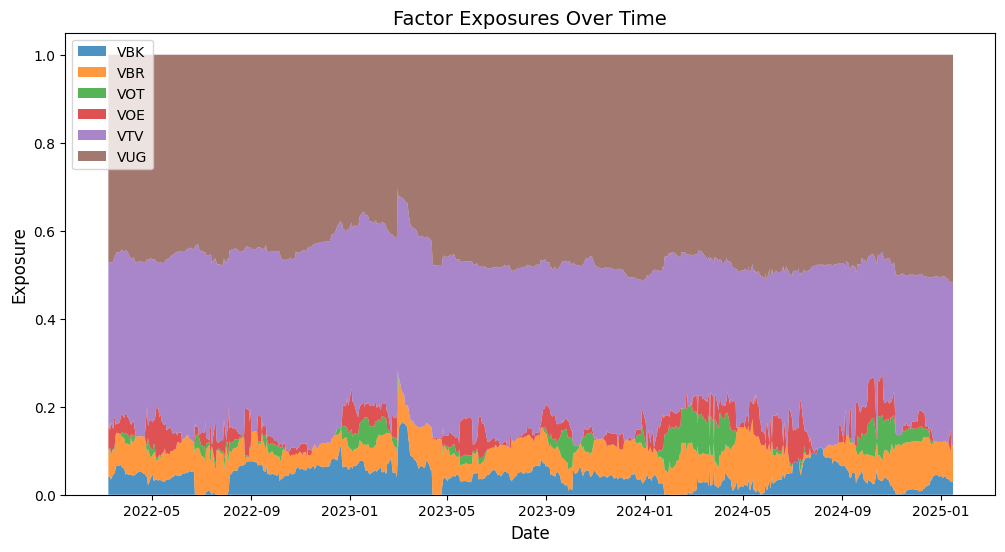

In [56]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.stackplot(results.index, results[tickers].T, labels=tickers, alpha=0.8)

plt.legend(loc='upper left', fontsize=10)
plt.title('Factor Exposures Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Exposure', fontsize=12)

plt.show()